In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_log_error
from gensim.models import word2vec
import jpholiday
import swifter
import datetime
from tqdm.notebook import tqdm
from sklearn.linear_model import BayesianRidge
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline
from utils import StratifiedGroupKFold
pd.options.display.max_rows = 1000

In [2]:
files = [
    '../output/MLP_oof_preds.joblib',
    '../output/LGB_oof_ypred.joblib',
    '../output/CBT_oof_preds.joblib',
    '../output/TabNet_oof_preds.joblib',
    '../output/XGB_oof_preds.joblib',
    #'../output/RFR_oof_preds.joblib',
    #'../output/EXR_oof_preds.joblib',
    #'../output/BYR_oof_preds.joblib'
]
oofs = []
y_preds = []
for file in files:
    oof, y_pred = joblib.load(file)
    oofs.append(pd.DataFrame(np.log1p(oof), columns=['Global_Sales']).add_prefix(file.split('/')[2][:3]))
    y_preds.append(pd.DataFrame(np.log1p(y_pred), columns=['Global_Sales']).add_prefix(file.split('/')[2][:3]))

In [3]:
oof = pd.concat(oofs, axis=1)
y_pred = pd.concat(y_preds, axis=1)

In [4]:
oof.corr()

,MLPGlobal_Sales,LGBGlobal_Sales,CBTGlobal_Sales,TabGlobal_Sales,XGBGlobal_Sales
MLPGlobal_Sales,1.000000,0.912367,0.906062,0.904264,0.904177
LGBGlobal_Sales,0.912367,1.000000,0.945817,0.869775,0.971774
CBTGlobal_Sales,0.906062,0.945817,1.000000,0.859822,0.947722
TabGlobal_Sales,0.904264,0.869775,0.859822,1.000000,0.862175
XGBGlobal_Sales,0.904177,0.971774,0.947722,0.862175,1.000000


In [5]:
train, test, groups = joblib.load('../output/features.joblib')

In [6]:
y_train = np.log1p(train['Global_Sales'])


In [7]:
for i in range(oof.shape[1]):
    print(f'{oof.columns[i]}: ', end='')
    print(mean_squared_log_error(np.expm1(y_train.values), np.expm1(oof.iloc[:, i].values)) ** .5)

MLPGlobal_Sales: 0.8966913673892108
LGBGlobal_Sales: 0.827341756904246
CBTGlobal_Sales: 0.865501207218099
TabGlobal_Sales: 0.927090275353453
XGBGlobal_Sales: 0.827261109202819


In [8]:
#X_train = np.log1p(oof.copy())
X_train = oof.copy()
y_train = np.log1p(train['Global_Sales'])
#X_test = np.log1p(y_pred.copy())
X_test = y_pred.copy()

X_train = X_train.loc[:, X_train.columns.str.contains('Global')]
X_test = X_test.loc[:, X_test.columns.str.contains('Global')]



In [9]:
def train_lgb(X_train, y_train, X_test):
    stratified_y = pd.cut(y_train, 10, labels=False)
    #kf = KFold(n_splits=5, shuffle=True, random_state=0)
    #kf = GroupKFold(n_splits=5)
    kf = StratifiedGroupKFold(n_splits=5, random_state=0)
    #kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof = np.zeros(X_train.shape[0])
    y_pred = np.zeros(X_test.shape[0])
    models = []

    for i, (train_index, valid_index) in enumerate(kf.split(X_train, y=stratified_y, groups=groups)):
        print(f'Start {i+1} fold')
        print('-' * 20)
        X_tr, y_tr = X_train.iloc[train_index, :], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[valid_index, :], y_train.iloc[valid_index]
        X_tes = X_test.copy()
        
        if False:
            lgb_train = lgb.Dataset(X_tr, y_tr)
            lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)
            lgb_params = {
                'objective': 'rmse',
                'metric': 'rmse',
                'max_depth': 3,
                'num_leaves': 2 ** 8,
                'learning_rate': 0.01,
                'bagging_fraction': 0.8,
                'feature_fraction': 1,
                'random_state': 0,
                'verbosity': -1
                }
            model = lgb.train(
                lgb_params,
                lgb_train,
                valid_sets=(lgb_train, lgb_valid),
                num_boost_round=100000000,
                early_stopping_rounds=1000,
                verbose_eval=1000
            )
        else:
            model = BayesianRidge(n_iter=1000)
            model.fit(X_tr, y_tr)
        oof[valid_index] = model.predict(X_val)
        y_pred += model.predict(X_tes) / 5
        models.append(model)
    
    return oof, y_pred, models

In [10]:
oof_st, y_pred_st, models = train_lgb(X_train, y_train, X_test)

Start 1 fold
--------------------
Start 2 fold
--------------------
Start 3 fold
--------------------
Start 4 fold
--------------------
Start 5 fold
--------------------


In [12]:
oof_st = np.where(oof_st < 0, 0, oof_st)
y_pred_st = np.where(y_pred_st < 0, 0, y_pred_st)

y_train = np.expm1(y_train)
oof_st = np.expm1(oof_st)
y_pred_st = np.expm1(y_pred_st)

print(mean_squared_log_error(y_train, oof_st) ** .5)

0.818679743744194


In [13]:
submit = pd.read_csv('../data/atmaCup8_sample-submission.csv')
submit['Global_Sales'] = y_pred_st
submit.to_csv('../output/20201214_stacking.csv', index=False)

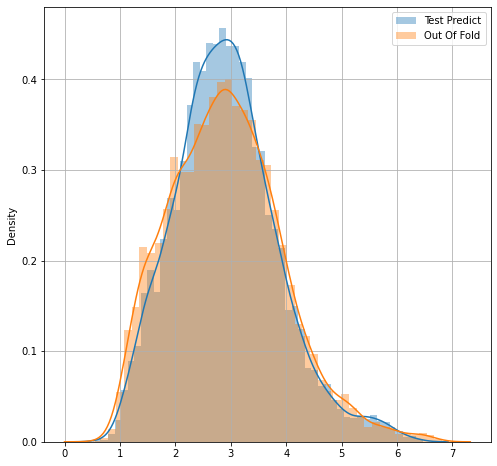

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(y_pred_st), label='Test Predict')
sns.distplot(np.log1p(oof_st), label='Out Of Fold')
ax.legend()
ax.grid()